In [2]:
!pip install pyarrow

In [3]:
!pip install scikit-learn --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 24.6 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [6]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge


In [8]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Taxi-experiment")

2025/07/01 17:42:05 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/07/01 17:42:05 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/workspaces/mlops/02-experiment-tracking/mlruns/1', creation_time=1751341650472, experiment_id='1', last_update_time=1751341650472, lifecycle_stage='active', name='Taxi-experiment', tags={}>

In [9]:
pd.__version__

'2.2.3'

In [10]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [11]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [12]:
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

In [13]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60 )

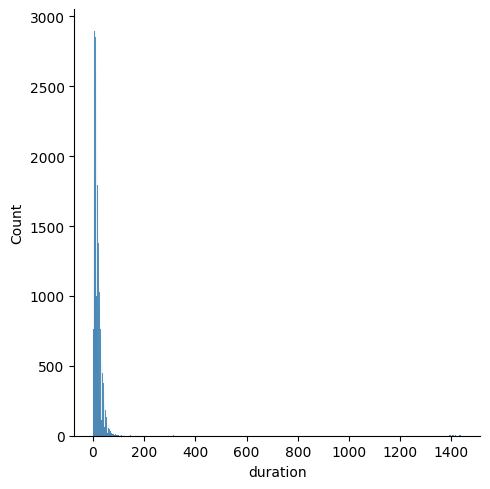

In [14]:
sns.displot(df.duration)

In [15]:
df.duration.describe(percentiles =[0.95,0.98,0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [16]:
#Since 99% data lies less than 68, we remove others as outliers
df = df[(df.duration >=1) & (df.duration<68)]

In [17]:
#Taking a subset of data for training
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [18]:
def root_mean_squared_error(y_pred,y_train):
    return np.sqrt(np.mean((np.array(y_train) - np.array(y_pred)) ** 2))

In [19]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values
with mlflow.start_run():
    mlflow.set_tag("developer","saravanan")
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.set_tag("model","LinearRegression")
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_train)
    rmse = root_mean_squared_error(y_pred,y_train)
    mlflow.log_metric("rmse",rmse)

/tmp/ipykernel_1884/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1884/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


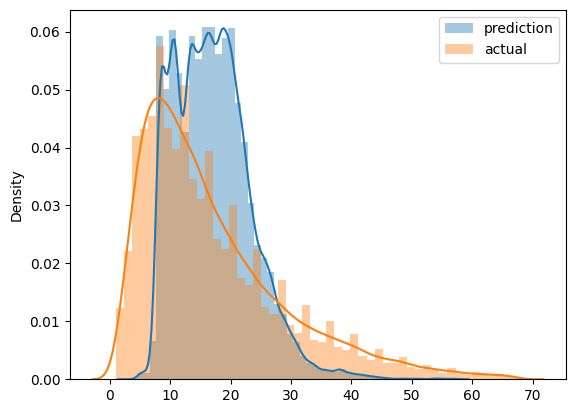

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [21]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [22]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [23]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet')

In [24]:
len(df_train), len(df_val)

(46307, 44218)

In [25]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [26]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [27]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [28]:
with mlflow.start_run():
    mlflow.set_tag("developer","saravanan")
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")
    mlflow.set_tag("model","LinearRegression")
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

/tmp/ipykernel_1884/2624495092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1884/2624495092.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


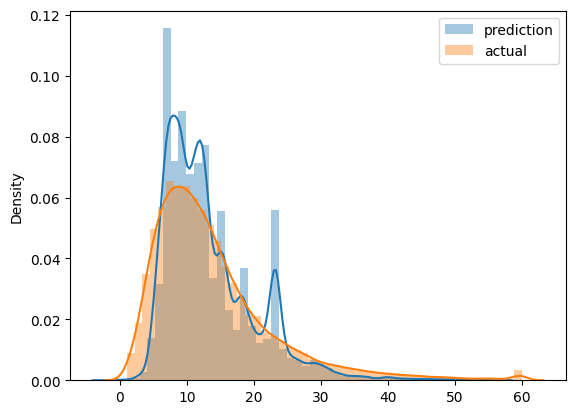

In [29]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [30]:
# !mkdir models
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [31]:
with mlflow.start_run():
    alpha = 0.01
    mlflow.set_tag("developer","saravanan")
    mlflow.log_param("train-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-01.parquet")
    mlflow.log_param("val-data-path","https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2025-02.parquet")
    mlflow.set_tag("model","LassoRegression")
    mlflow.log_param("alpha",alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse",rmse)

/tmp/ipykernel_1884/2624495092.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_1884/2624495092.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_val, label='actual')


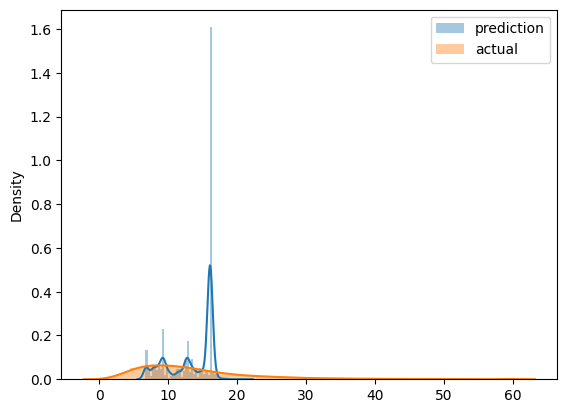

In [32]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_val, label='actual')

plt.legend()

In [64]:
!pip install hyperopt xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 35.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 33.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [xgboost]m1/2 [xgboost]


In [33]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import xgboost as xgb

/home/codespace/.python/current/lib/python3.12/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [34]:
train = xgb.DMatrix(X_train, label = y_train)
val = xgb.DMatrix(X_val, label = y_val)

In [72]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params = params,
            dtrain= train,
            num_boost_round = 1000,
            evals = [(val,'validarion')],
            early_stopping_rounds = 50
        )
        ypred = booster.predict(val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric('rmse',rmse)
    return {'loss':rmse,'status': STATUS_OK}

In [74]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn = objective,
    space = search_space,
    algo = tpe.suggest,
    max_evals = 50,
    trials = Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:21:31] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.05910                           
[1]	validarion-rmse:7.29505                           
[2]	validarion-rmse:6.74730                           
[3]	validarion-rmse:6.36340                           
[4]	validarion-rmse:6.09559                           
[5]	validarion-rmse:5.91156                           
[6]	validarion-rmse:5.78521                           
[7]	validarion-rmse:5.69926                           
[8]	validarion-rmse:5.63928                           
[9]	validarion-rmse:5.59569                           
[10]	validarion-rmse:5.56724                          
[11]	validarion-rmse:5.54544                          
[12]	validarion-rmse:5.53106                          
[13]	validarion-rmse:5.51764                          
[14]	validarion-rmse:5.50912                          
[15]	validarion-rmse:5.50045                          
[16]	validarion-rmse:5.49379                          
[17]	validarion-rmse:5.48852                          
[18]	valid

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:22:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.04302                                                   
[1]	validarion-rmse:5.61740                                                   
[2]	validarion-rmse:5.54839                                                   
[3]	validarion-rmse:5.53374                                                   
[4]	validarion-rmse:5.52511                                                   
[5]	validarion-rmse:5.52219                                                   
[6]	validarion-rmse:5.51805                                                   
[7]	validarion-rmse:5.51138                                                   
[8]	validarion-rmse:5.50961                                                   
[9]	validarion-rmse:5.50846                                                   
[10]	validarion-rmse:5.50507                                                  
[11]	validarion-rmse:5.50361                                                  
[12]	validarion-rmse:5.49778                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:22:10] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.31244                                                   
[1]	validarion-rmse:7.68288                                                   
[2]	validarion-rmse:7.18849                                                   
[3]	validarion-rmse:6.80447                                                   
[4]	validarion-rmse:6.50876                                                   
[5]	validarion-rmse:6.28355                                                   
[6]	validarion-rmse:6.11333                                                   
[7]	validarion-rmse:5.98447                                                   
[8]	validarion-rmse:5.88652                                                   
[9]	validarion-rmse:5.81172                                                   
[10]	validarion-rmse:5.75560                                                  
[11]	validarion-rmse:5.70911                                                  
[12]	validarion-rmse:5.67347                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:22:50] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.72650                                                   
[1]	validarion-rmse:8.38194                                                   
[2]	validarion-rmse:8.06929                                                   
[3]	validarion-rmse:7.78706                                                   
[4]	validarion-rmse:7.53270                                                   
[5]	validarion-rmse:7.30408                                                   
[6]	validarion-rmse:7.09884                                                   
[7]	validarion-rmse:6.91500                                                   
[8]	validarion-rmse:6.75073                                                   
[9]	validarion-rmse:6.60421                                                   
[10]	validarion-rmse:6.47360                                                  
[11]	validarion-rmse:6.35766                                                  
[12]	validarion-rmse:6.25388                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:24:12] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.52888                                                   
[1]	validarion-rmse:8.03229                                                   
[2]	validarion-rmse:7.60684                                                   
[3]	validarion-rmse:7.24363                                                   
[4]	validarion-rmse:6.93553                                                   
[5]	validarion-rmse:6.67563                                                   
[6]	validarion-rmse:6.45707                                                   
[7]	validarion-rmse:6.27469                                                   
[8]	validarion-rmse:6.12214                                                   
[9]	validarion-rmse:5.99561                                                   
[10]	validarion-rmse:5.89009                                                  
[11]	validarion-rmse:5.80273                                                  
[12]	validarion-rmse:5.73085                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:25:02] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.70473                                                   
[1]	validarion-rmse:5.81857                                                   
[2]	validarion-rmse:5.52753                                                   
[3]	validarion-rmse:5.43104                                                   
[4]	validarion-rmse:5.40254                                                   
[5]	validarion-rmse:5.39377                                                   
[6]	validarion-rmse:5.38820                                                   
[7]	validarion-rmse:5.39187                                                   
[8]	validarion-rmse:5.39573                                                   
[9]	validarion-rmse:5.39497                                                   
[10]	validarion-rmse:5.39587                                                  
[11]	validarion-rmse:5.39185                                                  
[12]	validarion-rmse:5.39343                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:25:18] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.00672                                                   
[1]	validarion-rmse:6.09052                                                   
[2]	validarion-rmse:5.69842                                                   
[3]	validarion-rmse:5.53123                                                   
[4]	validarion-rmse:5.46529                                                   
[5]	validarion-rmse:5.42884                                                   
[6]	validarion-rmse:5.40944                                                   
[7]	validarion-rmse:5.39680                                                   
[8]	validarion-rmse:5.39387                                                   
[9]	validarion-rmse:5.39253                                                   
[10]	validarion-rmse:5.38632                                                  
[11]	validarion-rmse:5.38491                                                  
[12]	validarion-rmse:5.38282                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:25:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.77677                                                   
[1]	validarion-rmse:5.60330                                                   
[2]	validarion-rmse:5.58661                                                   
[3]	validarion-rmse:5.56911                                                   
[4]	validarion-rmse:5.57045                                                   
[5]	validarion-rmse:5.57339                                                   
[6]	validarion-rmse:5.57734                                                   
[7]	validarion-rmse:5.57638                                                   
[8]	validarion-rmse:5.57895                                                   
[9]	validarion-rmse:5.57276                                                   
[10]	validarion-rmse:5.57268                                                  
[11]	validarion-rmse:5.57628                                                  
[12]	validarion-rmse:5.57554                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:25:40] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.12123                                                   
[1]	validarion-rmse:5.64713                                                   
[2]	validarion-rmse:5.54506                                                   
[3]	validarion-rmse:5.51267                                                   
[4]	validarion-rmse:5.49386                                                   
[5]	validarion-rmse:5.48896                                                   
[6]	validarion-rmse:5.46489                                                   
[7]	validarion-rmse:5.45952                                                   
[8]	validarion-rmse:5.45715                                                   
[9]	validarion-rmse:5.45324                                                   
[10]	validarion-rmse:5.44869                                                  
[11]	validarion-rmse:5.44573                                                  
[12]	validarion-rmse:5.44543                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:25:55] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.22268                                                   
[1]	validarion-rmse:7.53209                                                   
[2]	validarion-rmse:7.00059                                                   
[3]	validarion-rmse:6.59521                                                   
[4]	validarion-rmse:6.28994                                                   
[5]	validarion-rmse:6.06074                                                   
[6]	validarion-rmse:5.89025                                                   
[7]	validarion-rmse:5.76582                                                   
[8]	validarion-rmse:5.67399                                                   
[9]	validarion-rmse:5.60434                                                   
[10]	validarion-rmse:5.55072                                                  
[11]	validarion-rmse:5.51122                                                  
[12]	validarion-rmse:5.48207                        

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:26:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.68767                                                    
[1]	validarion-rmse:5.65937                                                    
[2]	validarion-rmse:5.63286                                                    
[3]	validarion-rmse:5.64053                                                    
[4]	validarion-rmse:5.63082                                                    
[5]	validarion-rmse:5.62294                                                    
[6]	validarion-rmse:5.62883                                                    
[7]	validarion-rmse:5.62816                                                    
[8]	validarion-rmse:5.62567                                                    
[9]	validarion-rmse:5.62527                                                    
[10]	validarion-rmse:5.63093                                                   
[11]	validarion-rmse:5.63550                                                   
[12]	validarion-rmse:5.63995            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:26:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.13708                                                    
[1]	validarion-rmse:6.17752                                                    
[2]	validarion-rmse:5.75005                                                    
[3]	validarion-rmse:5.55284                                                    
[4]	validarion-rmse:5.46133                                                    
[5]	validarion-rmse:5.41553                                                    
[6]	validarion-rmse:5.39267                                                    
[7]	validarion-rmse:5.37944                                                    
[8]	validarion-rmse:5.37427                                                    
[9]	validarion-rmse:5.37139                                                    
[10]	validarion-rmse:5.37004                                                   
[11]	validarion-rmse:5.36805                                                   
[12]	validarion-rmse:5.36644            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:26:46] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.54846                                                    
[1]	validarion-rmse:6.63959                                                    
[2]	validarion-rmse:6.13605                                                    
[3]	validarion-rmse:5.86099                                                    
[4]	validarion-rmse:5.71362                                                    
[5]	validarion-rmse:5.63078                                                    
[6]	validarion-rmse:5.57599                                                    
[7]	validarion-rmse:5.54524                                                    
[8]	validarion-rmse:5.52543                                                    
[9]	validarion-rmse:5.51382                                                    
[10]	validarion-rmse:5.50310                                                   
[11]	validarion-rmse:5.49427                                                   
[12]	validarion-rmse:5.48827            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:27:10] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.80818                                                    
[1]	validarion-rmse:8.53218                                                    
[2]	validarion-rmse:8.27712                                                    
[3]	validarion-rmse:8.04151                                                    
[4]	validarion-rmse:7.82445                                                    
[5]	validarion-rmse:7.62437                                                    
[6]	validarion-rmse:7.44040                                                    
[7]	validarion-rmse:7.27182                                                    
[8]	validarion-rmse:7.11672                                                    
[9]	validarion-rmse:6.97497                                                    
[10]	validarion-rmse:6.84524                                                   
[11]	validarion-rmse:6.72658                                                   
[12]	validarion-rmse:6.61849            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:28:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.75055                                                    
[1]	validarion-rmse:5.44155                                                    
[2]	validarion-rmse:5.40475                                                    
[3]	validarion-rmse:5.39504                                                    
[4]	validarion-rmse:5.39216                                                    
[5]	validarion-rmse:5.38827                                                    
[6]	validarion-rmse:5.38504                                                    
[7]	validarion-rmse:5.37362                                                    
[8]	validarion-rmse:5.37495                                                    
[9]	validarion-rmse:5.37158                                                    
[10]	validarion-rmse:5.37300                                                   
[11]	validarion-rmse:5.37259                                                   
[12]	validarion-rmse:5.37133            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:28:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validarion-rmse:6.51982                                                    
[2]	validarion-rmse:6.06876                                                    
[3]	validarion-rmse:5.84069                                                    
[4]	validarion-rmse:5.72390                                                    
[5]	validarion-rmse:5.66098                                                    
[6]	validarion-rmse:5.62477                                                    
[7]	validarion-rmse:5.60553                                                    
[8]	validarion-rmse:5.59250                                                    
[9]	validarion-rmse:5.57870                                                    
[10]	validarion-rmse:5.56776                                                   
[11]	validarion-rmse:5.55542                                                   
[12]	validarion-rmse:5.54133                                                   
[13]	validarion-rmse:5.53315            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:29:03] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validarion-rmse:6.80062                                                    
[2]	validarion-rmse:6.25875                                                    
[3]	validarion-rmse:5.94079                                                    
[4]	validarion-rmse:5.74923                                                    
[5]	validarion-rmse:5.63653                                                    
[6]	validarion-rmse:5.56271                                                    
[7]	validarion-rmse:5.52015                                                    
[8]	validarion-rmse:5.48922                                                    
[9]	validarion-rmse:5.46966                                                    
[10]	validarion-rmse:5.45414                                                   
[11]	validarion-rmse:5.44392                                                   
[12]	validarion-rmse:5.43787                                                   
[13]	validarion-rmse:5.43169            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:29:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.72581                                                    
[1]	validarion-rmse:6.84798                                                    
[2]	validarion-rmse:6.28905                                                    
[3]	validarion-rmse:5.95070                                                    
[4]	validarion-rmse:5.75553                                                    
[5]	validarion-rmse:5.62637                                                    
[6]	validarion-rmse:5.55215                                                    
[7]	validarion-rmse:5.50894                                                    
[8]	validarion-rmse:5.47398                                                    
[9]	validarion-rmse:5.45957                                                    
[10]	validarion-rmse:5.44932                                                   
[11]	validarion-rmse:5.44002                                                   
[12]	validarion-rmse:5.43811            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:29:42] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.44903                                                    
[1]	validarion-rmse:7.89858                                                    
[2]	validarion-rmse:7.44129                                                    
[3]	validarion-rmse:7.06353                                                    
[4]	validarion-rmse:6.75239                                                    
[5]	validarion-rmse:6.49772                                                    
[6]	validarion-rmse:6.28991                                                    
[7]	validarion-rmse:6.11922                                                    
[8]	validarion-rmse:5.98178                                                    
[9]	validarion-rmse:5.87138                                                    
[10]	validarion-rmse:5.77780                                                   
[11]	validarion-rmse:5.70591                                                   
[12]	validarion-rmse:5.64856            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:30:07] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.79952                                                    
[1]	validarion-rmse:6.94102                                                    
[2]	validarion-rmse:6.36573                                                    
[3]	validarion-rmse:6.04149                                                    
[4]	validarion-rmse:5.84081                                                    
[5]	validarion-rmse:5.70844                                                    
[6]	validarion-rmse:5.63306                                                    
[7]	validarion-rmse:5.59839                                                    
[8]	validarion-rmse:5.57209                                                    
[9]	validarion-rmse:5.55174                                                    
[10]	validarion-rmse:5.54575                                                   
[11]	validarion-rmse:5.53884                                                   
[12]	validarion-rmse:5.53114            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:30:44] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validarion-rmse:5.78831                                                    
[2]	validarion-rmse:5.62028                                                    
[3]	validarion-rmse:5.57415                                                    
[4]	validarion-rmse:5.56109                                                    
[5]	validarion-rmse:5.54360                                                    
[6]	validarion-rmse:5.54115                                                    
[7]	validarion-rmse:5.54226                                                    
[8]	validarion-rmse:5.53944                                                    
[9]	validarion-rmse:5.53248                                                    
[10]	validarion-rmse:5.52806                                                   
[11]	validarion-rmse:5.52258                                                   
[12]	validarion-rmse:5.51913                                                   
[13]	validarion-rmse:5.51764            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:30:52] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.12560                                                    
[1]	validarion-rmse:7.39204                                                    
[2]	validarion-rmse:6.85264                                                    
[3]	validarion-rmse:6.46163                                                    
[4]	validarion-rmse:6.18092                                                    
[5]	validarion-rmse:5.98208                                                    
[6]	validarion-rmse:5.84285                                                    
[7]	validarion-rmse:5.74192                                                    
[8]	validarion-rmse:5.67080                                                    
[9]	validarion-rmse:5.61987                                                    
[10]	validarion-rmse:5.58378                                                   
[11]	validarion-rmse:5.55811                                                   
[12]	validarion-rmse:5.53844            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:31:21] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[7]	validarion-rmse:6.68214                                                    
[8]	validarion-rmse:6.53299                                                    
[9]	validarion-rmse:6.40862                                                    
[10]	validarion-rmse:6.29982                                                   
[11]	validarion-rmse:6.20784                                                   
[12]	validarion-rmse:6.12996                                                   
[13]	validarion-rmse:6.06074                                                   
[14]	validarion-rmse:6.00404                                                   
[15]	validarion-rmse:5.95602                                                   
[16]	validarion-rmse:5.91412                                                   
[17]	validarion-rmse:5.87699                                                   
[18]	validarion-rmse:5.84560                                                   
[19]	validarion-rmse:5.82056            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:31:48] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.99229                                                    
[1]	validarion-rmse:7.18565                                                    
[2]	validarion-rmse:6.61168                                                    
[3]	validarion-rmse:6.21284                                                    
[4]	validarion-rmse:5.93719                                                    
[5]	validarion-rmse:5.75012                                                    
[6]	validarion-rmse:5.62642                                                    
[7]	validarion-rmse:5.54253                                                    
[8]	validarion-rmse:5.48594                                                    
[9]	validarion-rmse:5.44821                                                    
[10]	validarion-rmse:5.42142                                                   
[11]	validarion-rmse:5.40456                                                   
[12]	validarion-rmse:5.39209            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:32:14] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.32450                                                    
[1]	validarion-rmse:5.65374                                                    
[2]	validarion-rmse:5.50320                                                    
[3]	validarion-rmse:5.46096                                                    
[4]	validarion-rmse:5.43952                                                    
[5]	validarion-rmse:5.42585                                                    
[6]	validarion-rmse:5.40132                                                    
[7]	validarion-rmse:5.39893                                                    
[8]	validarion-rmse:5.39106                                                    
[9]	validarion-rmse:5.38896                                                    
[10]	validarion-rmse:5.38528                                                   
[11]	validarion-rmse:5.38108                                                   
[12]	validarion-rmse:5.37773            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:32:24] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.34553                                                    
[1]	validarion-rmse:7.73760                                                    
[2]	validarion-rmse:7.24677                                                    
[3]	validarion-rmse:6.86359                                                    
[4]	validarion-rmse:6.55387                                                    
[5]	validarion-rmse:6.31900                                                    
[6]	validarion-rmse:6.13623                                                    
[7]	validarion-rmse:5.98255                                                    
[8]	validarion-rmse:5.87510                                                    
[9]	validarion-rmse:5.77917                                                    
[10]	validarion-rmse:5.71273                                                   
[11]	validarion-rmse:5.66409                                                   
[12]	validarion-rmse:5.61936            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:32:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[8]	validarion-rmse:6.72173                                                    
[9]	validarion-rmse:6.58716                                                    
[10]	validarion-rmse:6.47090                                                   
[11]	validarion-rmse:6.36857                                                   
[12]	validarion-rmse:6.27942                                                   
[13]	validarion-rmse:6.20068                                                   
[14]	validarion-rmse:6.13360                                                   
[15]	validarion-rmse:6.07294                                                   
[16]	validarion-rmse:6.01989                                                   
[17]	validarion-rmse:5.97539                                                   
[18]	validarion-rmse:5.93673                                                   
[19]	validarion-rmse:5.90189                                                   
[20]	validarion-rmse:5.87133            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:33:20] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.63497                                                    
[1]	validarion-rmse:5.85367                                                    
[2]	validarion-rmse:5.59442                                                    
[3]	validarion-rmse:5.51953                                                    
[4]	validarion-rmse:5.49504                                                    
[5]	validarion-rmse:5.48564                                                    
[6]	validarion-rmse:5.48259                                                    
[7]	validarion-rmse:5.47716                                                    
[8]	validarion-rmse:5.47239                                                    
[9]	validarion-rmse:5.47373                                                    
[10]	validarion-rmse:5.47173                                                   
[11]	validarion-rmse:5.47226                                                   
[12]	validarion-rmse:5.47106            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:33:36] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.24182                                                    
[1]	validarion-rmse:7.56167                                                    
[2]	validarion-rmse:7.03030                                                    
[3]	validarion-rmse:6.62079                                                    
[4]	validarion-rmse:6.30871                                                    
[5]	validarion-rmse:6.07305                                                    
[6]	validarion-rmse:5.89263                                                    
[7]	validarion-rmse:5.75906                                                    
[8]	validarion-rmse:5.65758                                                    
[9]	validarion-rmse:5.58303                                                    
[10]	validarion-rmse:5.52814                                                   
[11]	validarion-rmse:5.48649                                                   
[12]	validarion-rmse:5.45475            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:34:06] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[2]	validarion-rmse:6.64106                                                    
[3]	validarion-rmse:6.27870                                                    
[4]	validarion-rmse:6.03952                                                    
[5]	validarion-rmse:5.88248                                                    
[6]	validarion-rmse:5.77772                                                    
[7]	validarion-rmse:5.70548                                                    
[8]	validarion-rmse:5.65629                                                    
[9]	validarion-rmse:5.62256                                                    
[10]	validarion-rmse:5.59842                                                   
[11]	validarion-rmse:5.58073                                                   
[12]	validarion-rmse:5.56624                                                   
[13]	validarion-rmse:5.55530                                                   
[14]	validarion-rmse:5.54721            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:34:41] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.76741                                                    
[1]	validarion-rmse:8.45698                                                    
[2]	validarion-rmse:8.17326                                                    
[3]	validarion-rmse:7.91416                                                    
[4]	validarion-rmse:7.67800                                                    
[5]	validarion-rmse:7.46328                                                    
[6]	validarion-rmse:7.26813                                                    
[7]	validarion-rmse:7.09086                                                    
[8]	validarion-rmse:6.93056                                                    
[9]	validarion-rmse:6.78582                                                    
[10]	validarion-rmse:6.65521                                                   
[11]	validarion-rmse:6.53741                                                   
[12]	validarion-rmse:6.43154            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:36:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.45260                                                    
[1]	validarion-rmse:7.90457                                                    
[2]	validarion-rmse:7.44495                                                    
[3]	validarion-rmse:7.06426                                                    
[4]	validarion-rmse:6.75067                                                    
[5]	validarion-rmse:6.49344                                                    
[6]	validarion-rmse:6.28111                                                    
[7]	validarion-rmse:6.10747                                                    
[8]	validarion-rmse:5.97160                                                    
[9]	validarion-rmse:5.85569                                                    
[10]	validarion-rmse:5.76458                                                   
[11]	validarion-rmse:5.68940                                                   
[12]	validarion-rmse:5.62742            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:36:25] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.51156                                                    
[1]	validarion-rmse:5.44016                                                    
[2]	validarion-rmse:5.42345                                                    
[3]	validarion-rmse:5.40602                                                    
[4]	validarion-rmse:5.40315                                                    
[5]	validarion-rmse:5.39761                                                    
[6]	validarion-rmse:5.40381                                                    
[7]	validarion-rmse:5.40898                                                    
[8]	validarion-rmse:5.41081                                                    
[9]	validarion-rmse:5.40754                                                    
[10]	validarion-rmse:5.41053                                                   
[11]	validarion-rmse:5.40684                                                   
[12]	validarion-rmse:5.40496            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:36:35] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.41131                                                    
[1]	validarion-rmse:6.48788                                                    
[2]	validarion-rmse:5.99596                                                    
[3]	validarion-rmse:5.73780                                                    
[4]	validarion-rmse:5.59942                                                    
[5]	validarion-rmse:5.52866                                                    
[6]	validarion-rmse:5.48896                                                    
[7]	validarion-rmse:5.46534                                                    
[8]	validarion-rmse:5.44942                                                    
[9]	validarion-rmse:5.44056                                                    
[10]	validarion-rmse:5.43668                                                   
[11]	validarion-rmse:5.42888                                                   
[12]	validarion-rmse:5.42712            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:36:45] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.13398                                                    
[1]	validarion-rmse:7.39762                                                    
[2]	validarion-rmse:6.84675                                                    
[3]	validarion-rmse:6.44018                                                    
[4]	validarion-rmse:6.14578                                                    
[5]	validarion-rmse:5.92992                                                    
[6]	validarion-rmse:5.77246                                                    
[7]	validarion-rmse:5.66204                                                    
[8]	validarion-rmse:5.58063                                                    
[9]	validarion-rmse:5.52325                                                    
[10]	validarion-rmse:5.48192                                                   
[11]	validarion-rmse:5.45046                                                   
[12]	validarion-rmse:5.42600            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:37:00] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.76679                                                    
[1]	validarion-rmse:5.87032                                                    
[2]	validarion-rmse:5.55802                                                    
[3]	validarion-rmse:5.45151                                                    
[4]	validarion-rmse:5.41428                                                    
[5]	validarion-rmse:5.39939                                                    
[6]	validarion-rmse:5.38883                                                    
[7]	validarion-rmse:5.38289                                                    
[8]	validarion-rmse:5.37993                                                    
[9]	validarion-rmse:5.37660                                                    
[10]	validarion-rmse:5.36868                                                   
[11]	validarion-rmse:5.36861                                                   
[12]	validarion-rmse:5.36349            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:37:12] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.48507                                                    
[1]	validarion-rmse:5.76415                                                    
[2]	validarion-rmse:5.58034                                                    
[3]	validarion-rmse:5.52899                                                    
[4]	validarion-rmse:5.50946                                                    
[5]	validarion-rmse:5.49866                                                    
[6]	validarion-rmse:5.49706                                                    
[7]	validarion-rmse:5.48945                                                    
[8]	validarion-rmse:5.47537                                                    
[9]	validarion-rmse:5.47480                                                    
[10]	validarion-rmse:5.47345                                                   
[11]	validarion-rmse:5.47102                                                   
[12]	validarion-rmse:5.47126            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:37:22] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.42750                                                    
[1]	validarion-rmse:7.86576                                                    
[2]	validarion-rmse:7.40453                                                    
[3]	validarion-rmse:7.02862                                                    
[4]	validarion-rmse:6.72382                                                    
[5]	validarion-rmse:6.47950                                                    
[6]	validarion-rmse:6.28400                                                    
[7]	validarion-rmse:6.12736                                                    
[8]	validarion-rmse:6.00161                                                    
[9]	validarion-rmse:5.90161                                                    
[10]	validarion-rmse:5.82272                                                   
[11]	validarion-rmse:5.76028                                                   
[12]	validarion-rmse:5.71059            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:38:06] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.57530                                                    
[1]	validarion-rmse:8.11262                                                    
[2]	validarion-rmse:7.71121                                                    
[3]	validarion-rmse:7.36509                                                    
[4]	validarion-rmse:7.06746                                                    
[5]	validarion-rmse:6.81277                                                    
[6]	validarion-rmse:6.59490                                                    
[7]	validarion-rmse:6.40936                                                    
[8]	validarion-rmse:6.25178                                                    
[9]	validarion-rmse:6.11884                                                    
[10]	validarion-rmse:6.00689                                                   
[11]	validarion-rmse:5.91255                                                   
[12]	validarion-rmse:5.83330            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:38:57] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.06639                                                    
[1]	validarion-rmse:6.16271                                                    
[2]	validarion-rmse:5.75050                                                    
[3]	validarion-rmse:5.60858                                                    
[4]	validarion-rmse:5.53736                                                    
[5]	validarion-rmse:5.50045                                                    
[6]	validarion-rmse:5.49081                                                    
[7]	validarion-rmse:5.48404                                                    
[8]	validarion-rmse:5.48110                                                    
[9]	validarion-rmse:5.47733                                                    
[10]	validarion-rmse:5.47417                                                   
[11]	validarion-rmse:5.46952                                                   
[12]	validarion-rmse:5.46839            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.74408                                                    
[1]	validarion-rmse:5.43108                                                    
[2]	validarion-rmse:5.41121                                                    
[3]	validarion-rmse:5.40556                                                    
[4]	validarion-rmse:5.41094                                                    
[5]	validarion-rmse:5.41332                                                    
[6]	validarion-rmse:5.41485                                                    
[7]	validarion-rmse:5.41685                                                    
[8]	validarion-rmse:5.41831                                                    
[9]	validarion-rmse:5.42011                                                    
[10]	validarion-rmse:5.42148                                                   
[11]	validarion-rmse:5.41834                                                   
[12]	validarion-rmse:5.41989            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:27] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.56455                                                    
[1]	validarion-rmse:6.62412                                                    
[2]	validarion-rmse:6.08550                                                    
[3]	validarion-rmse:5.78126                                                    
[4]	validarion-rmse:5.60170                                                    
[5]	validarion-rmse:5.50677                                                    
[6]	validarion-rmse:5.44712                                                    
[7]	validarion-rmse:5.41244                                                    
[8]	validarion-rmse:5.38812                                                    
[9]	validarion-rmse:5.37467                                                    
[10]	validarion-rmse:5.36498                                                   
[11]	validarion-rmse:5.35661                                                   
[12]	validarion-rmse:5.35584            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:39:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validarion-rmse:8.39532                                                    
[2]	validarion-rmse:8.09018                                                    
[3]	validarion-rmse:7.81513                                                    
[4]	validarion-rmse:7.56783                                                    
[5]	validarion-rmse:7.34605                                                    
[6]	validarion-rmse:7.14737                                                    
[7]	validarion-rmse:6.96955                                                    
[8]	validarion-rmse:6.81090                                                    
[9]	validarion-rmse:6.66988                                                    
[10]	validarion-rmse:6.54434                                                   
[11]	validarion-rmse:6.43290                                                   
[12]	validarion-rmse:6.33424                                                   
[13]	validarion-rmse:6.24648            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:40:53] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.36355                                                    
[1]	validarion-rmse:6.44160                                                    
[2]	validarion-rmse:5.98024                                                    
[3]	validarion-rmse:5.75208                                                    
[4]	validarion-rmse:5.63597                                                    
[5]	validarion-rmse:5.57467                                                    
[6]	validarion-rmse:5.53987                                                    
[7]	validarion-rmse:5.51768                                                    
[8]	validarion-rmse:5.50415                                                    
[9]	validarion-rmse:5.49328                                                    
[10]	validarion-rmse:5.48433                                                   
[11]	validarion-rmse:5.46974                                                   
[12]	validarion-rmse:5.46263            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:41:08] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[1]	validarion-rmse:5.53484                                                    
[2]	validarion-rmse:5.51830                                                    
[3]	validarion-rmse:5.50363                                                    
[4]	validarion-rmse:5.49295                                                    
[5]	validarion-rmse:5.47834                                                    
[6]	validarion-rmse:5.47105                                                    
[7]	validarion-rmse:5.46553                                                    
[8]	validarion-rmse:5.46058                                                    
[9]	validarion-rmse:5.45122                                                    
[10]	validarion-rmse:5.44471                                                   
[11]	validarion-rmse:5.43583                                                   
[12]	validarion-rmse:5.43344                                                   
[13]	validarion-rmse:5.41131            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:41:13] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.17360                                                    
[1]	validarion-rmse:5.67171                                                    
[2]	validarion-rmse:5.56245                                                    
[3]	validarion-rmse:5.52129                                                    
[4]	validarion-rmse:5.49948                                                    
[5]	validarion-rmse:5.48982                                                    
[6]	validarion-rmse:5.47675                                                    
[7]	validarion-rmse:5.46941                                                    
[8]	validarion-rmse:5.46363                                                    
[9]	validarion-rmse:5.46189                                                    
[10]	validarion-rmse:5.45938                                                   
[11]	validarion-rmse:5.45739                                                   
[12]	validarion-rmse:5.45681            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:41:29] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:5.81976                                                    
[1]	validarion-rmse:5.61802                                                    
[2]	validarion-rmse:5.59024                                                    
[3]	validarion-rmse:5.54850                                                    
[4]	validarion-rmse:5.52270                                                    
[5]	validarion-rmse:5.51757                                                    
[6]	validarion-rmse:5.51121                                                    
[7]	validarion-rmse:5.50930                                                    
[8]	validarion-rmse:5.50364                                                    
[9]	validarion-rmse:5.50482                                                    
[10]	validarion-rmse:5.49706                                                   
[11]	validarion-rmse:5.49248                                                   
[12]	validarion-rmse:5.49145            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:41:45] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:7.80451                                                    
[1]	validarion-rmse:6.93612                                                    
[2]	validarion-rmse:6.38941                                                    
[3]	validarion-rmse:6.03273                                                    
[4]	validarion-rmse:5.81925                                                    
[5]	validarion-rmse:5.70459                                                    
[6]	validarion-rmse:5.61768                                                    
[7]	validarion-rmse:5.56091                                                    
[8]	validarion-rmse:5.52901                                                    
[9]	validarion-rmse:5.50972                                                    
[10]	validarion-rmse:5.49866                                                   
[11]	validarion-rmse:5.48879                                                   
[12]	validarion-rmse:5.48338            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:42:05] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:6.77963                                                    
[1]	validarion-rmse:5.88114                                                    
[2]	validarion-rmse:5.56818                                                    
[3]	validarion-rmse:5.46637                                                    
[4]	validarion-rmse:5.42995                                                    
[5]	validarion-rmse:5.41352                                                    
[6]	validarion-rmse:5.40417                                                    
[7]	validarion-rmse:5.39819                                                    
[8]	validarion-rmse:5.39585                                                    
[9]	validarion-rmse:5.38460                                                    
[10]	validarion-rmse:5.37771                                                   
[11]	validarion-rmse:5.37661                                                   
[12]	validarion-rmse:5.37550            

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [15:42:23] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()



[0]	validarion-rmse:8.15659                                                    
[1]	validarion-rmse:7.43311                                                    
[2]	validarion-rmse:6.88506                                                    
[3]	validarion-rmse:6.47890                                                    
[4]	validarion-rmse:6.17857                                                    
[5]	validarion-rmse:5.95918                                                    
[6]	validarion-rmse:5.79914                                                    
[7]	validarion-rmse:5.68255                                                    
[8]	validarion-rmse:5.59916                                                    
[9]	validarion-rmse:5.53892                                                    
[10]	validarion-rmse:5.49534                                                   
[11]	validarion-rmse:5.46121                                                   
[12]	validarion-rmse:5.43422            

In [35]:
best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }
mlflow.xgboost.autolog()

booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(val, 'validation')],
        early_stopping_rounds=50
    )


2025/07/01 17:42:36 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca81eecad6ff41949e720b5d07bff8e5', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:42:38] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:8.56745
[1]	validation-rmse:8.10033
[2]	validation-rmse:7.69739
[3]	validation-rmse:7.35105
[4]	validation-rmse:7.05239
[5]	validation-rmse:6.80020
[6]	validation-rmse:6.58162
[7]	validation-rmse:6.39726
[8]	validation-rmse:6.24197
[9]	validation-rmse:6.11059
[10]	validation-rmse:6.00193
[11]	validation-rmse:5.90700
[12]	validation-rmse:5.82752
[13]	validation-rmse:5.76123
[14]	validation-rmse:5.70306
[15]	validation-rmse:5.65560
[16]	validation-rmse:5.61619
[17]	validation-rmse:5.58065
[18]	validation-rmse:5.55157
[19]	validation-rmse:5.52734
[20]	validation-rmse:5.50858
[21]	validation-rmse:5.48872
[22]	validation-rmse:5.47379
[23]	validation-rmse:5.45957
[24]	validation-rmse:5.44705
[25]	validation-rmse:5.43706
[26]	validation-rmse:5.42713
[27]	validation-rmse:5.41891
[28]	validation-rmse:5.41283
[29]	validation-rmse:5.40819
[30]	validation-rmse:5.40244
[31]	validation-rmse:5.39854
[32]	validation-rmse:5.39446
[33]	validation-rmse:5.39004
[34]	validation-rmse:5.3

2025/07/01 17:43:20 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2025/07/01 17:43:20 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/01 17:43:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/.python/current/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [17:43:20] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/07/01 17:43:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [36]:
mlflow.xgboost.autolog(disable=True)

In [39]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")

/home/codespace/.python/current/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:47:10] WARNING: /workspace/src/objective/regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-rmse:8.56745
[1]	validation-rmse:8.10033
[2]	validation-rmse:7.69739
[3]	validation-rmse:7.35105
[4]	validation-rmse:7.05239
[5]	validation-rmse:6.80020
[6]	validation-rmse:6.58162
[7]	validation-rmse:6.39726
[8]	validation-rmse:6.24197
[9]	validation-rmse:6.11059
[10]	validation-rmse:6.00193
[11]	validation-rmse:5.90700
[12]	validation-rmse:5.82752
[13]	validation-rmse:5.76123
[14]	validation-rmse:5.70306
[15]	validation-rmse:5.65560
[16]	validation-rmse:5.61619
[17]	validation-rmse:5.58065
[18]	validation-rmse:5.55157
[19]	validation-rmse:5.52734
[20]	validation-rmse:5.50858
[21]	validation-rmse:5.48872
[22]	validation-rmse:5.47379
[23]	validation-rmse:5.45957
[24]	validation-rmse:5.44705
[25]	validation-rmse:5.43706
[26]	validation-rmse:5.42713
[27]	validation-rmse:5.41891
[28]	validation-rmse:5.41283
[29]	validation-rmse:5.40819
[30]	validation-rmse:5.40244
[31]	validation-rmse:5.39854
[32]	validation-rmse:5.39446
[33]	validation-rmse:5.39004
[34]	validation-rmse:5.3

2025/07/01 17:47:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/home/codespace/.python/current/lib/python3.12/site-packages/mlflow/xgboost/__init__.py:168: UserWarning: [17:47:50] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  xgb_model.save_model(model_data_path)
2025/07/01 17:47:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
